## Centroid Clustering 
We will cover one of the most popular algorithms K-means

In [1]:
#libraries 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs,make_moons
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Circle, ConnectionPatch
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score


# Set random seed and style
np.random.seed(42)

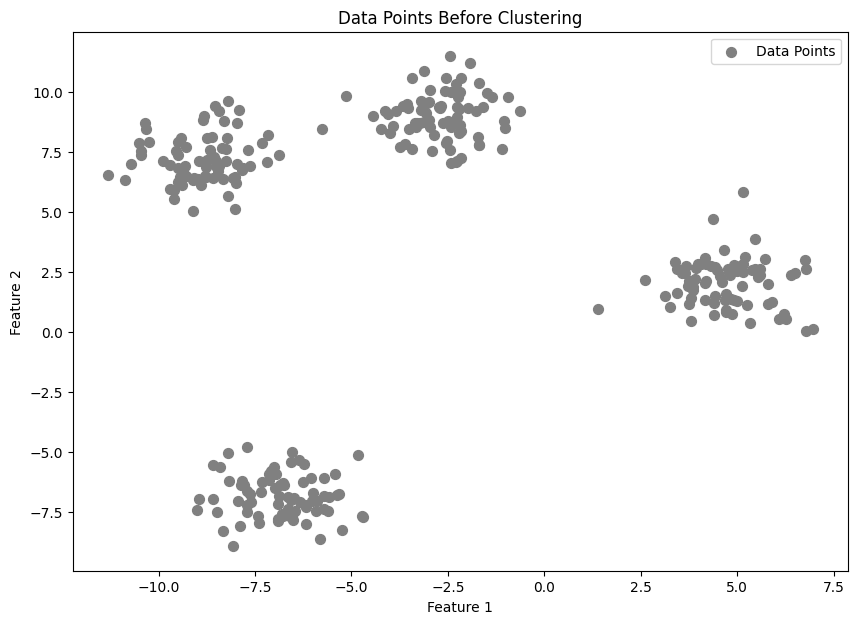

In [2]:
# Simulate some data for clustering
X, y = make_blobs(n_samples=300, centers=4, random_state=42)


# Plotting initial data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], s=50, c='gray', label='Data Points')
plt.title("Data Points Before Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()



### 1. Initial Centroid Selection

In the first step, K-Means selects random initial centroids. Let's visualize the starting positions.


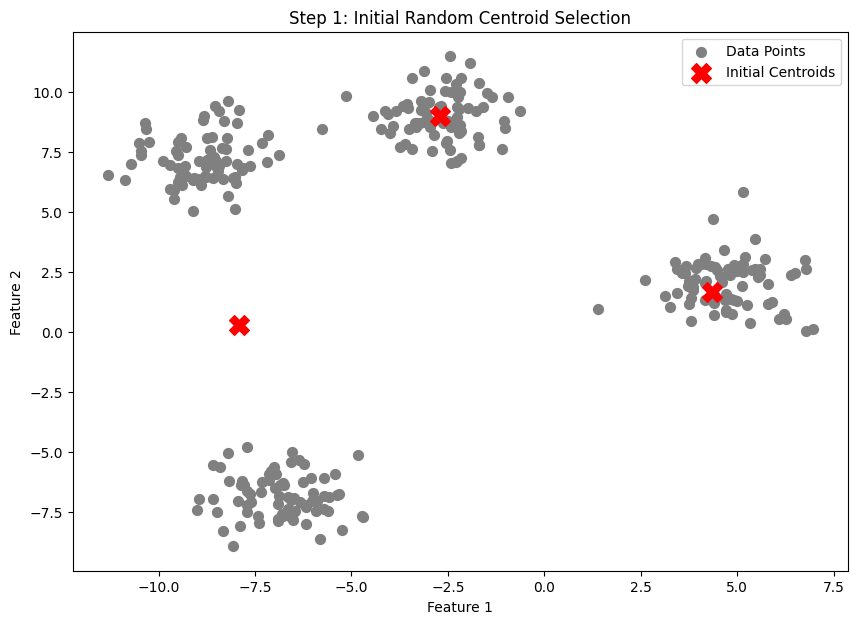

In [3]:
# Initialize KMeans with only one iteration to capture the initial step
kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=1, random_state=42)
kmeans.fit(X)

# Plot initial centroids and data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], s=50, c='gray', label='Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Initial Centroids', marker='X')
plt.title("Step 1: Initial Random Centroid Selection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


### 2. Assigning Points to Nearest Centroid

Next, each data point is assigned to the nearest centroid, forming preliminary clusters. Below, we show data points colored by their assigned cluster.


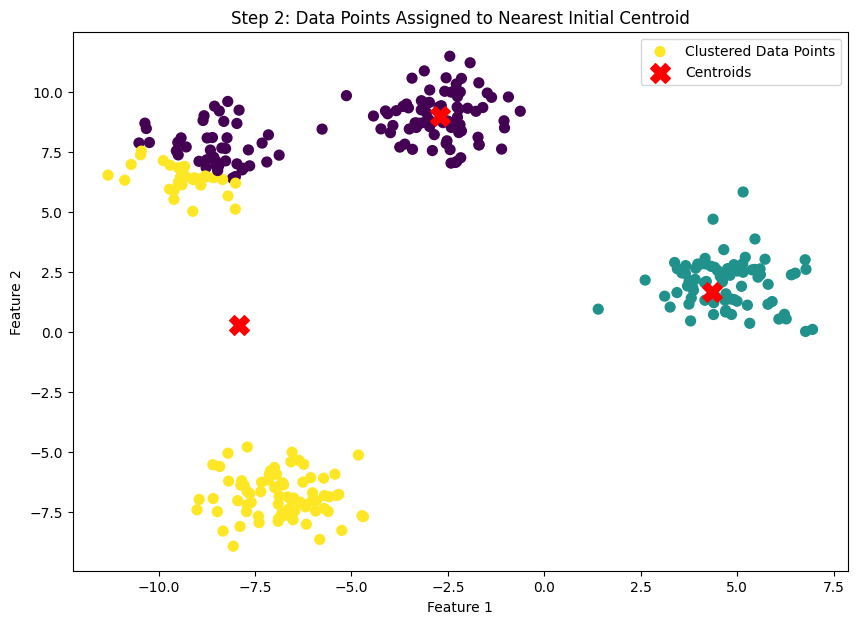

In [4]:


# Assign data points to nearest centroid
labels = kmeans.predict(X)

# Plot data points with color-coded clusters
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', label='Clustered Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids', marker='X')
plt.title("Step 2: Data Points Assigned to Nearest Initial Centroid")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

### 3. Updating Centroids

After assigning points, the centroids are updated by calculating the mean of points in each cluster. We display the centroid movement here.


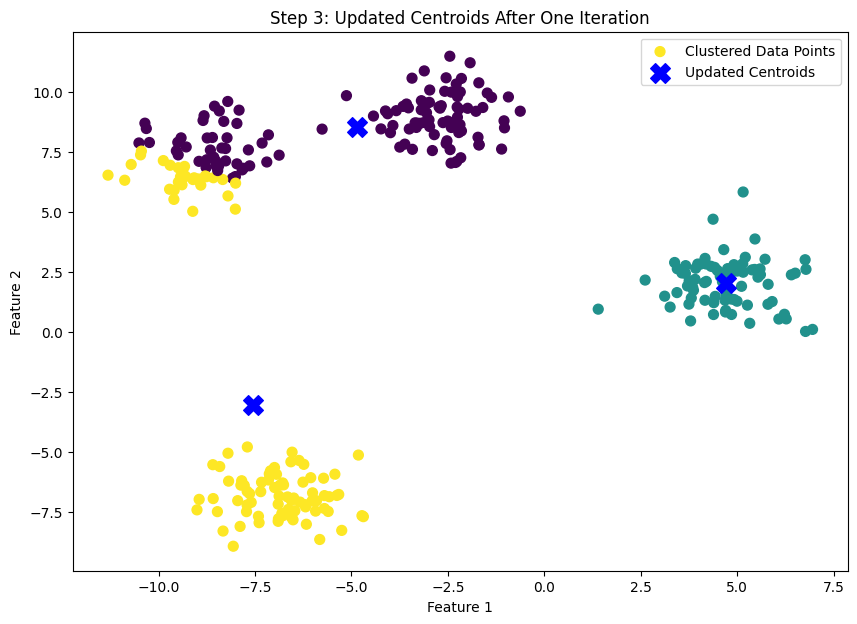

In [5]:
# Update centroids by running another iteration
kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=2, random_state=42)
kmeans.fit(X)

# Plot updated centroids
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', label='Clustered Data Points')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='blue', label='Updated Centroids', marker='X')
plt.title("Step 3: Updated Centroids After One Iteration")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


### 4. Convergence

The algorithm repeats these steps until centroids no longer move significantly. This usually indicates that the clusters have stabilized. Below is the final output of the algorithm.


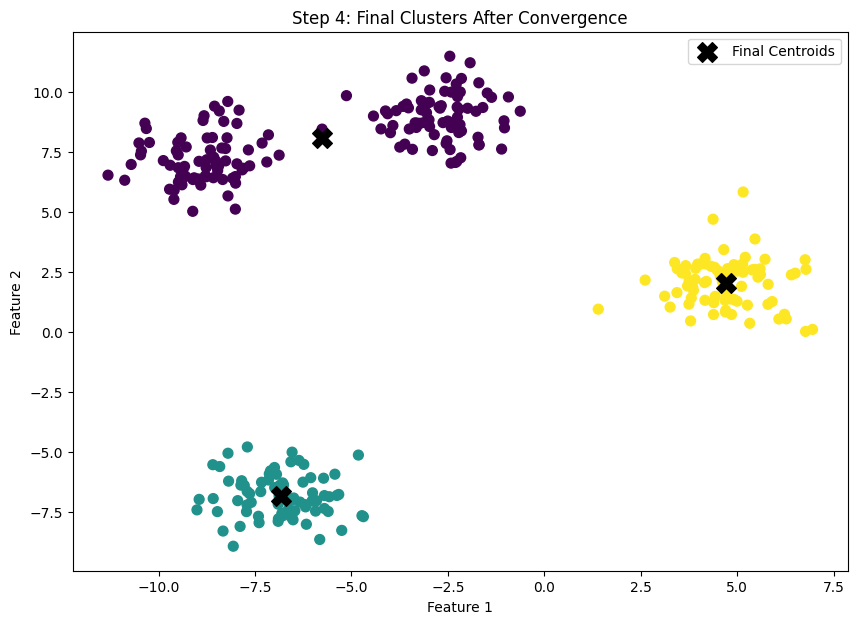

In [6]:


# Run KMeans until convergence
kmeans_final = KMeans(n_clusters=3, random_state=42)
kmeans_final.fit(X)

# Plot final clustering
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=kmeans_final.labels_, s=50, cmap='viridis')
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1], s=200, c='black', label='Final Centroids', marker='X')
plt.title("Step 4: Final Clusters After Convergence")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()



### What can be a problem here ?
How can we choose the number of clusters ?

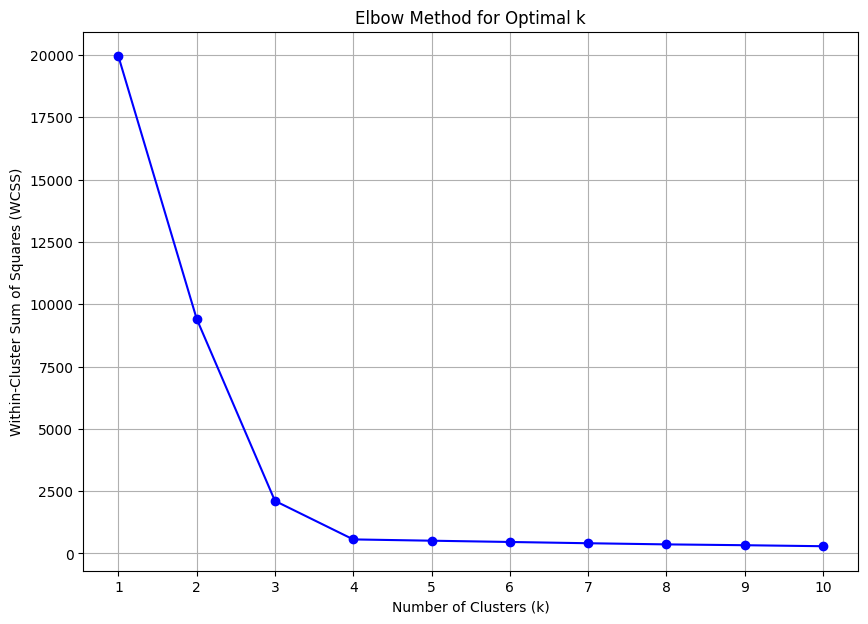

In [7]:
# Calculate WCSS for a range of cluster numbers
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 7))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# we will talk about metrics more next session but just a brief intro to one metric

### Understanding Within-Cluster Sum of Squares (WCSS)

**WCSS**, or **Within-Cluster Sum of Squares**, is a metric that quantifies the total variance within each cluster in a K-Means model. It’s calculated as the sum of the squared distances between each data point and its assigned cluster centroid. 



### Why WCSS is Important

Lower WCSS values indicate that points within clusters are closer to each other, forming more compact clusters. As we increase the number of clusters \( k \), WCSS typically decreases because clusters become smaller and more specific. However, increasing \( k \) beyond a certain point may not significantly reduce WCSS, which shows that adding more clusters does not improve the clustering meaningfully.

This is where the **Elbow Method** comes in, helping us choose an optimal \( k \) where the reduction in WCSS begins to level off. The point where the "elbow" occurs in the WCSS plot suggests the optimal number of clusters.


## Hierarchial Clustering 
Hierarchical clustering is an unsupervised learning algorithm that creates a hierarchy of clusters. 
It can be performed in two ways:
- Agglomerative (bottom-up): Start with individual points as clusters and merge them
- Divisive (top-down): Start with one cluster and divide it recursively

This notebook focuses on agglomerative clustering, which is more commonly used.

In [8]:

# Create simple dataset for visualization
X = np.array([
    [2, 2],   # Point A
    [2.5, 2], # Point B
    [2, 2.5], # Point C
    [6, 6],   # Point D
    [6.5, 6], # Point E
])
# Calculate distance matrix
distances = squareform(pdist(X))
# Function to plot points and clusters
def plot_clustering_step(X, clusters, step_num, title, connections=None):
    plt.figure(figsize=(10, 8))
    
    # Plot all points
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot clusters with different colors
    for i, cluster in enumerate(clusters):
        cluster = np.array(cluster)
        plt.scatter(cluster[:, 0], cluster[:, 1], c=[colors[i]], s=200, label=f'Cluster {i+1}')
    
    # Add connections if specified
    if connections:
        for (p1, p2) in connections:
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', alpha=0.5)
    
    # Add labels
    for i, (x, y) in enumerate(X):
        plt.annotate(f'Point {chr(65+i)}', (x, y), xytext=(10, 10), 
                    textcoords='offset points')
    
    plt.title(f'Step {step_num}: {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


### Step 1
Each point starts as its own cluster

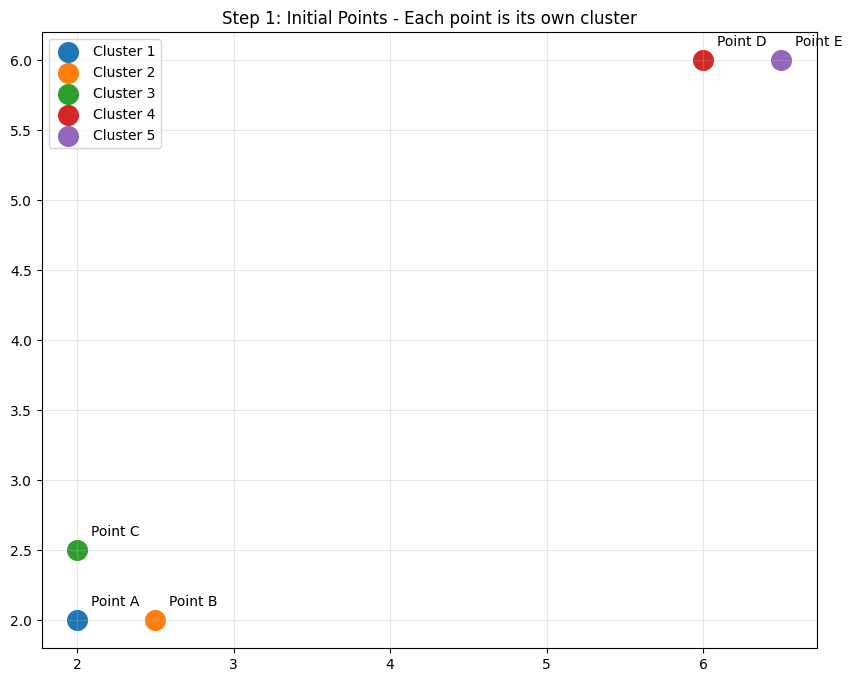

In [9]:

clusters = [[point] for point in X]
plot_clustering_step(X, clusters, 1, "Initial Points - Each point is its own cluster")

### Step 2
Merge the two closest/most similiar pair into a cluster

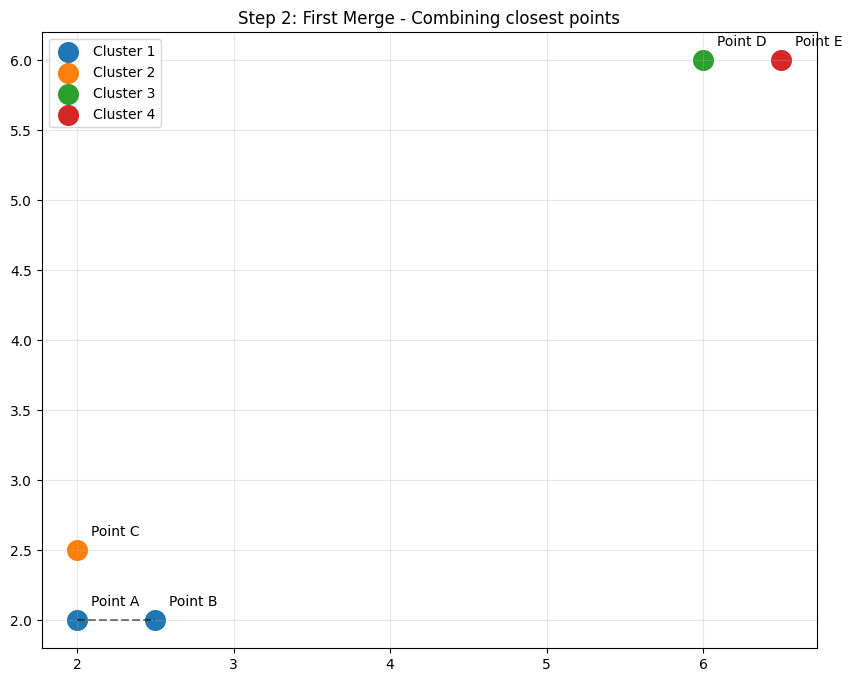

In [10]:
# Find closest pair (excluding self-distances)
dist_matrix = distances.copy()
np.fill_diagonal(dist_matrix, np.inf)
min_i, min_j = np.unravel_index(dist_matrix.argmin(), dist_matrix.shape)

clusters = [[X[min_i], X[min_j]]] + [[point] for idx, point in enumerate(X) if idx not in [min_i, min_j]]
connections = [(X[min_i], X[min_j])]
plot_clustering_step(X, clusters, 2, "First Merge - Combining closest points", connections)

### Step 3
Find the next closest pair (point or cluster) and merge them

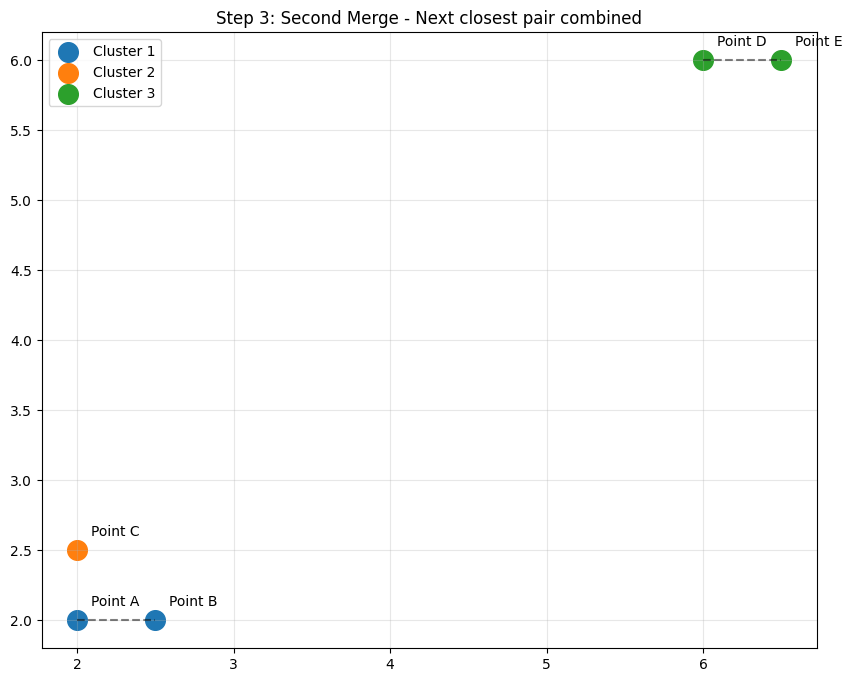

In [11]:
clusters = [
    [X[min_i], X[min_j]], # First cluster
    [X[2]], # Point C
    [X[3], X[4]], # Points D and E
]
connections = [(X[min_i], X[min_j]), (X[3], X[4])]
plot_clustering_step(X, clusters, 3, "Second Merge - Next closest pair combined", connections)

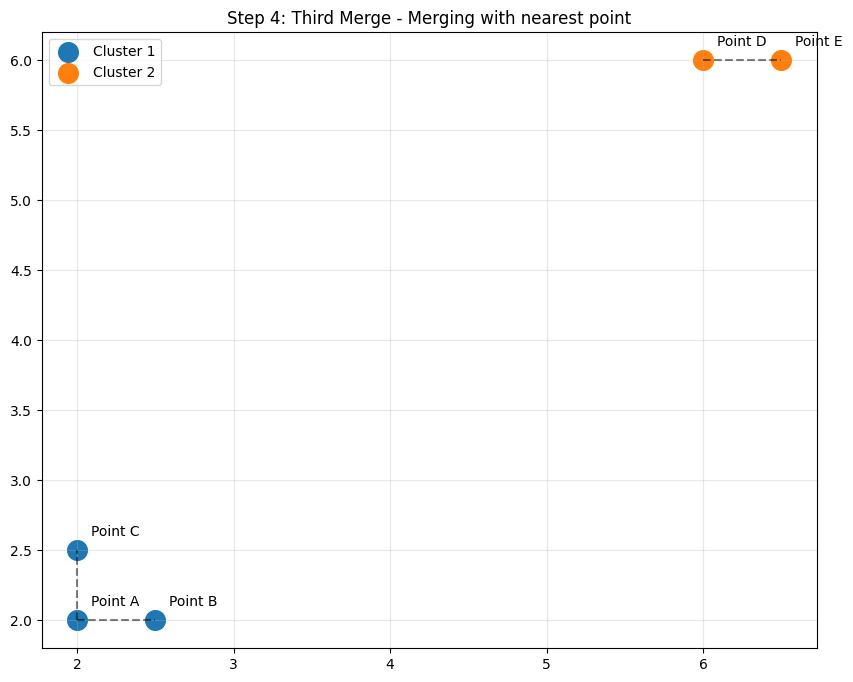

In [12]:
### Step 4
clusters = [
    [X[min_i], X[min_j], X[2]], # First cluster with Point C
    [X[3], X[4]], # Points D and E
]
connections = [(X[min_i], X[min_j]), (X[3], X[4]), (X[min_i], X[2])]
plot_clustering_step(X, clusters, 4, "Third Merge - Merging with nearest point", connections)


### Final step

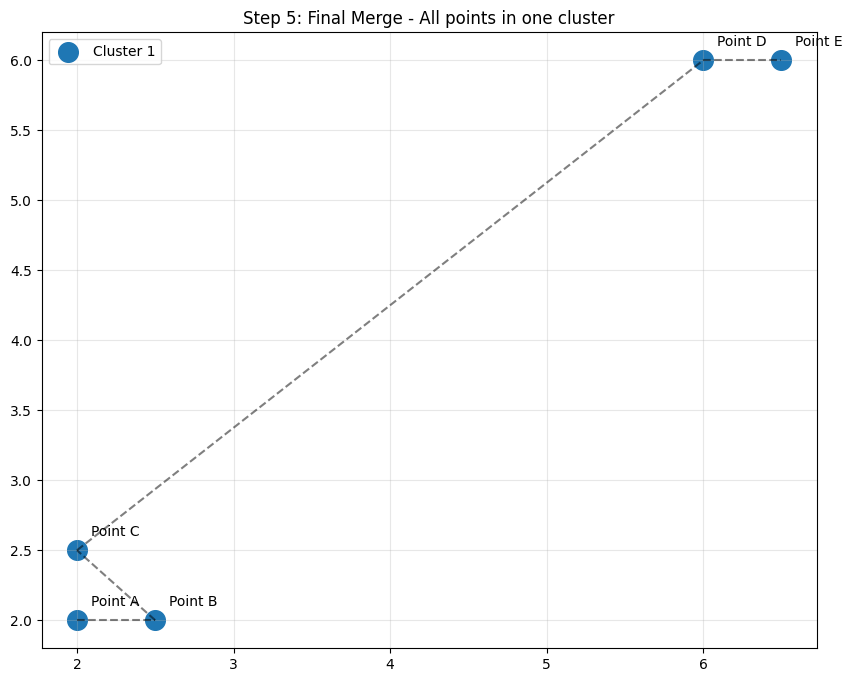

In [13]:
clusters = [
    [X[0], X[1], X[2], X[3], X[4]], # All points in one cluster
]
connections = [(X[0], X[1]), (X[3], X[4]), (X[1], X[2]), (X[2], X[3])]
plot_clustering_step(X, clusters, 5, "Final Merge - All points in one cluster", connections)


### Dendrogram

A dendrogram is a tree diagram that shows the hierarchical relationship between objects.
It's a key visualization tool for understanding how clusters are formed.

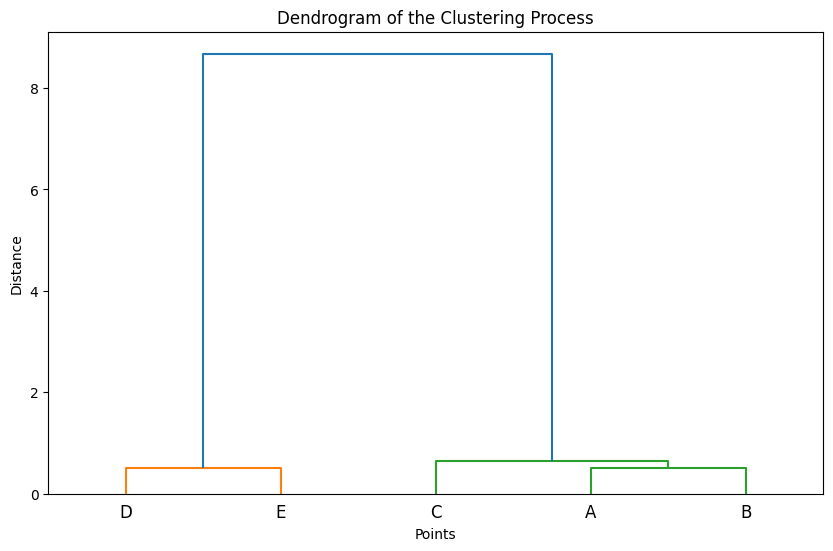

In [14]:
plt.figure(figsize=(10, 6))
linkage_matrix = linkage(X, method='ward')
dendrogram(linkage_matrix, labels=['A', 'B', 'C', 'D', 'E'])
plt.title('Dendrogram of the Clustering Process')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.show()


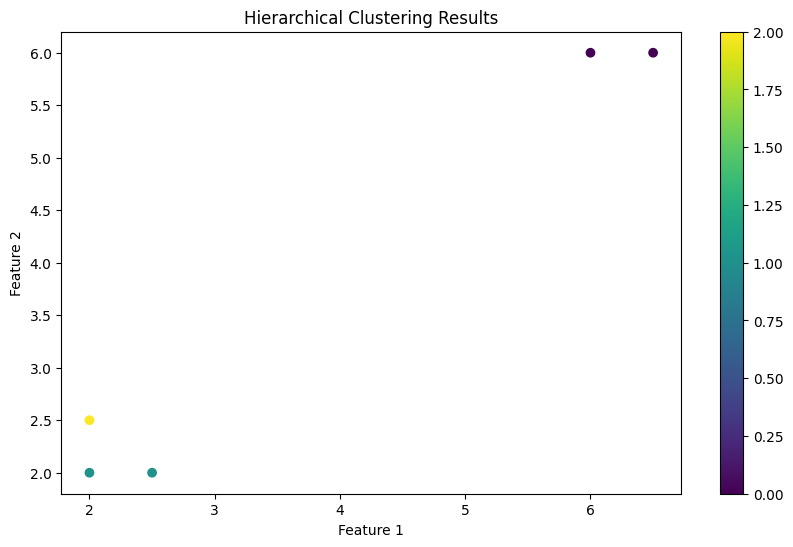

In [15]:
clustering = AgglomerativeClustering(n_clusters=3)
clusters = clustering.fit_predict(X)

# Visualize the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('Hierarchical Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter)
plt.show()

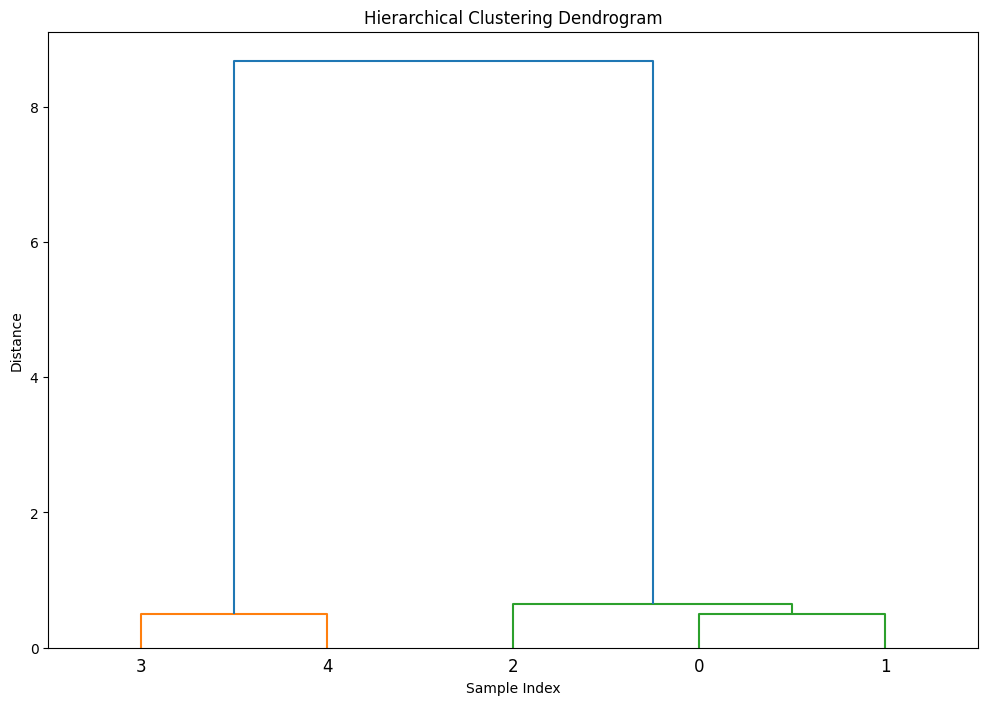

In [16]:
# Calculate the linkage matrix
linkage_matrix = linkage(X, method='ward')

# Create dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

#### Density clustering
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups together points that are close to each other while marking points in low-density regions as outliers.

In [17]:
### Helper function 

def plot_dbscan_step(X, epsilon, min_samples, step_num, title, center_point=None, radius=None, core_points=None, border_points=None, noise_points=None, connections=None):
    """
    Plot a step in the DBSCAN algorithm
    """
    plt.figure(figsize=(10, 8))
    
    # Plot all points initially in grey
    plt.scatter(X[:, 0], X[:, 1], c='grey', s=100, alpha=0.5, label='Unclassified')
    
    # Plot epsilon radius if specified
    if center_point is not None and radius is not None:
        circle = plt.Circle(center_point, radius, fill=False, linestyle='--', color='red', alpha=0.5)
        plt.gca().add_artist(circle)
        plt.scatter([center_point[0]], [center_point[1]], c='red', s=150, marker='*', label='Center Point')

    # Plot core points
    if core_points is not None:
        plt.scatter(X[core_points][:, 0], X[core_points][:, 1], 
                   c='blue', s=100, label='Core Points')
    
    # Plot border points
    if border_points is not None:
        plt.scatter(X[border_points][:, 0], X[border_points][:, 1], 
                   c='green', s=100, label='Border Points')
    
    # Plot noise points
    if noise_points is not None:
        plt.scatter(X[noise_points][:, 0], X[noise_points][:, 1], 
                   c='red', s=100, label='Noise Points')
    
    # Plot connections
    if connections is not None:
        for p1, p2 in connections:
            plt.plot([X[p1, 0], X[p2, 0]], [X[p1, 1], X[p2, 1]], 'k--', alpha=0.3)
    
    plt.title(f'Step {step_num}: {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


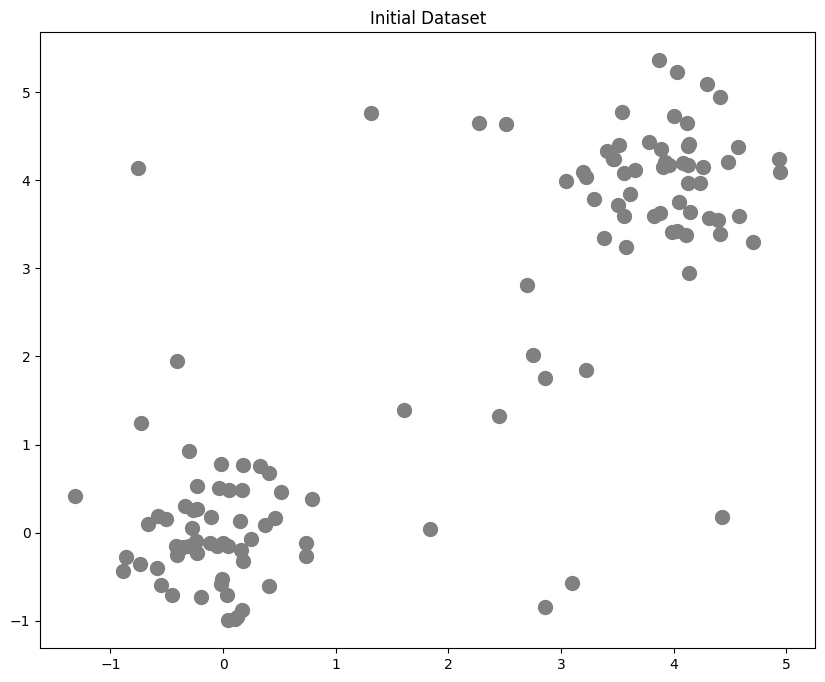

In [18]:

# 1. Generate Sample Dataset
# Create main clusters
X1, _ = make_blobs(n_samples=100, centers=[[0,0], [4,4]], cluster_std=0.5)
# Add some noise points
X2 = np.random.uniform(-1, 5, (20, 2))
X = np.vstack([X1, X2])

# Plot initial dataset
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c='grey', s=100)
plt.title('Initial Dataset')
plt.show()

### DBSCAN
For each point in your dataset, the algorithm will:
> Check its epsilon neighborhood (the circle around it) and count the neighbors within this radius

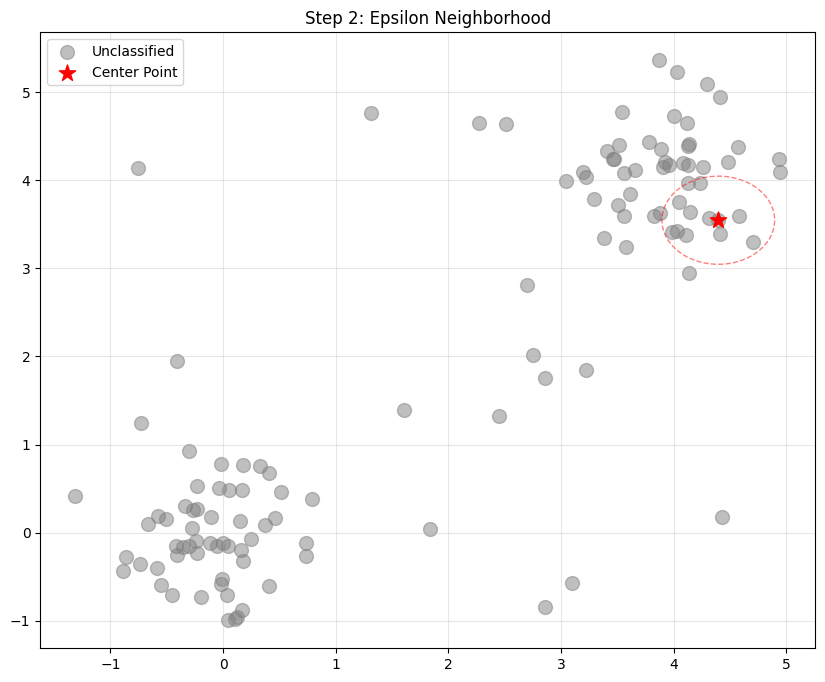

In [19]:
epsilon = 0.5
center_idx = 50  # Choose a point to demonstrate
plot_dbscan_step(X, epsilon, min_samples=5, step_num=2,
                 title="Epsilon Neighborhood",
                 center_point=X[center_idx],
                 radius=epsilon)

## Step 2 
A point becomes a Core Point if:

>It has at least MinPoints within its epsilon radius
Including itself in the count


>Core points are like the "hearts" of clusters
They represent areas of high density

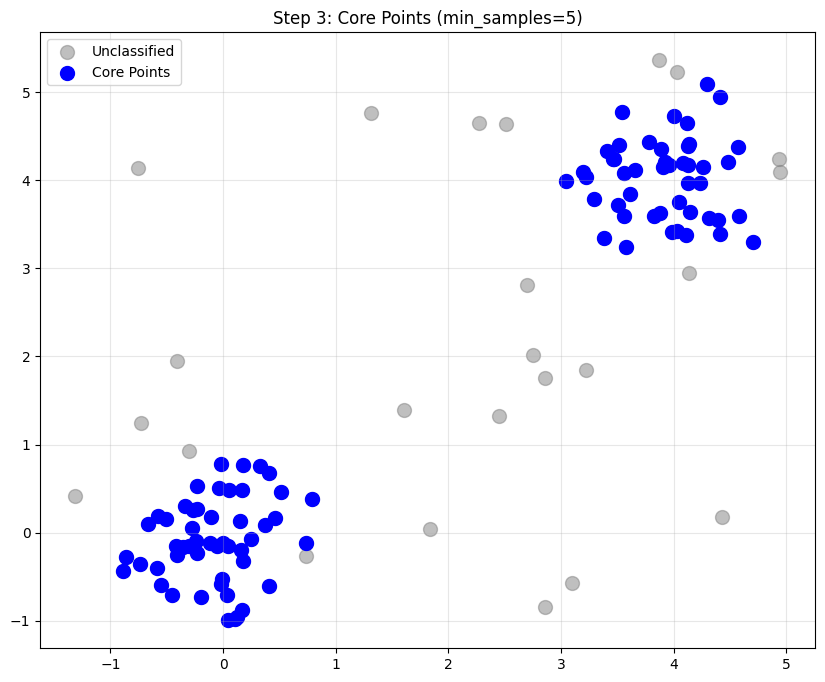

In [20]:
distances = squareform(pdist(X))

# Find core points
min_samples = 5
core_mask = np.sum(distances <= epsilon, axis=1) >= min_samples
core_points = np.where(core_mask)[0]

plot_dbscan_step(X, epsilon, min_samples, step_num=3,
                 title=f"Core Points (min_samples={min_samples})",
                 core_points=core_points)

### Step 3 
. Finding Border Points

A point becomes a Border Point if:

>It is not a core point
But it is within epsilon distance of a core point


>Border points are like the "edges" of clusters


Step 4: Identify Border Points


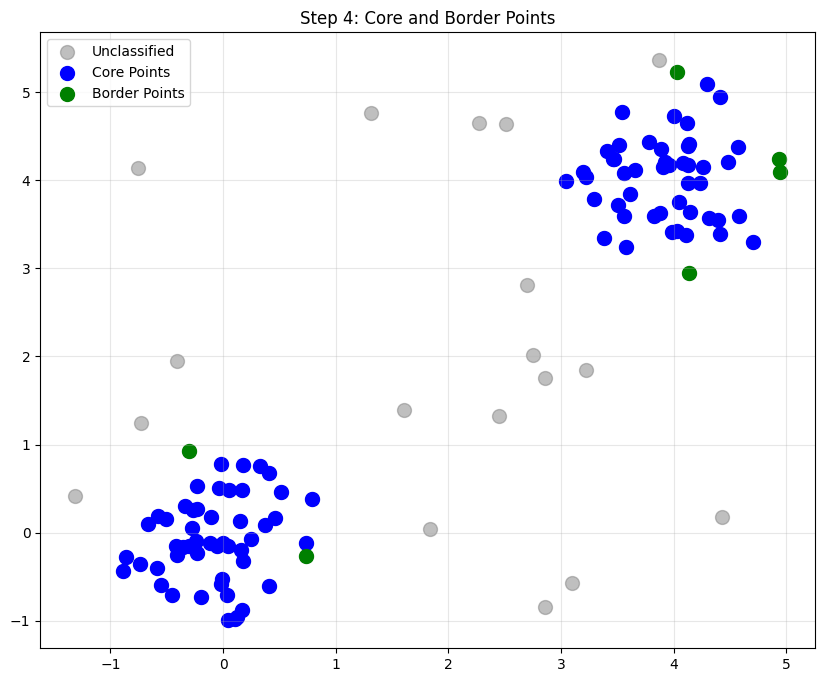

In [21]:


# 4. Identify Border Points
print("\nStep 4: Identify Border Points")
# Find border points
border_points = []
for i in range(len(X)):
    if i not in core_points:  # Not a core point
        # Check if point is within epsilon of any core point
        if any(distances[i, core_idx] <= epsilon for core_idx in core_points):
            border_points.append(i)

border_points = np.array(border_points)
plot_dbscan_step(X, epsilon, min_samples, step_num=4,
                 title="Core and Border Points",
                 core_points=core_points,
                 border_points=border_points)

 ### Step 4
 Finding Noise Points

A point is labeled as Noise if:

>It is not a core point
It is not a border point
It's too far from any cluster to belong


>Also called outliers
These points are in low-density regions


Step 5: Identify Noise Points


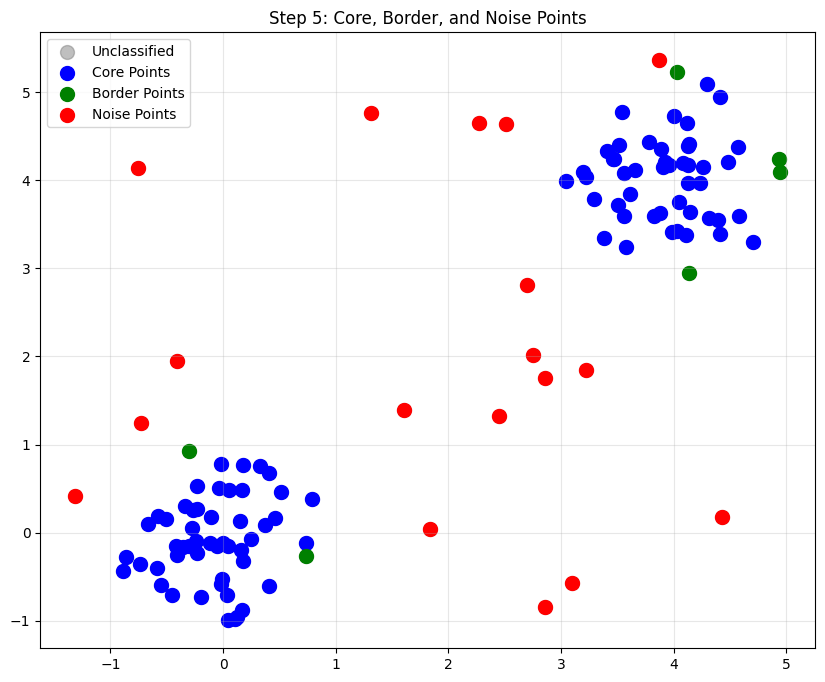

In [22]:

# 5. Identify Noise Points
print("\nStep 5: Identify Noise Points")
# Find noise points
all_clustered = np.concatenate([core_points, border_points])
noise_points = np.array([i for i in range(len(X)) if i not in all_clustered])

plot_dbscan_step(X, epsilon, min_samples, step_num=5,
                 title="Core, Border, and Noise Points",
                 core_points=core_points,
                 border_points=border_points,
                 noise_points=noise_points)

## Step 5
. Forming Clusters

>Find all core points that are within epsilon distance
Add them to the same cluster
Add any border points that are within epsilon of these core points



Step 6: Connect Core Points


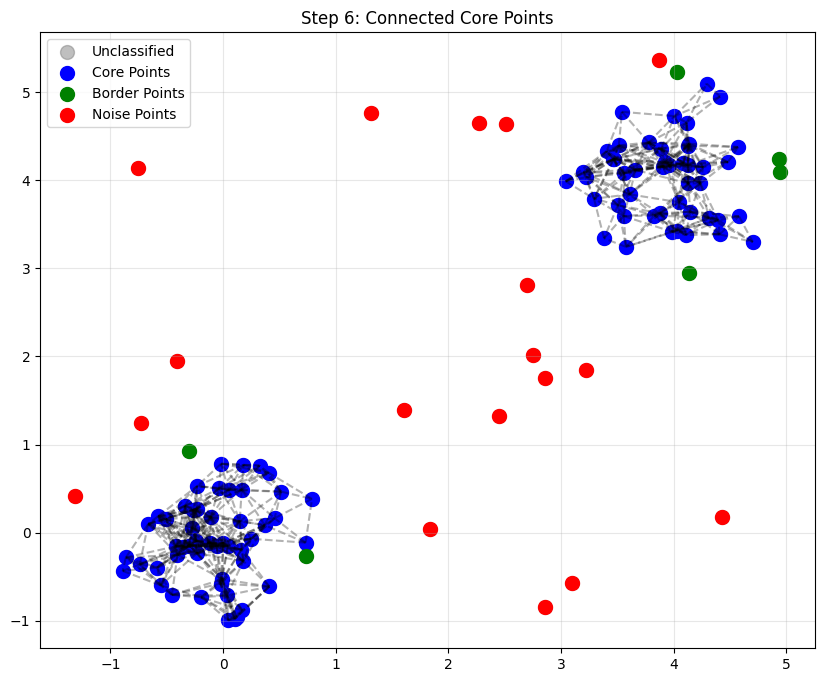

In [23]:
# 6. Connect Core Points
print("\nStep 6: Connect Core Points")
# Find connections between core points
connections = []
for i in core_points:
    for j in core_points:
        if i < j and distances[i, j] <= epsilon:
            connections.append((i, j))

plot_dbscan_step(X, epsilon, min_samples, step_num=6,
                 title="Connected Core Points",
                 core_points=core_points,
                 border_points=border_points,
                 noise_points=noise_points,
                 connections=connections)


Step 7: Final DBSCAN Clustering


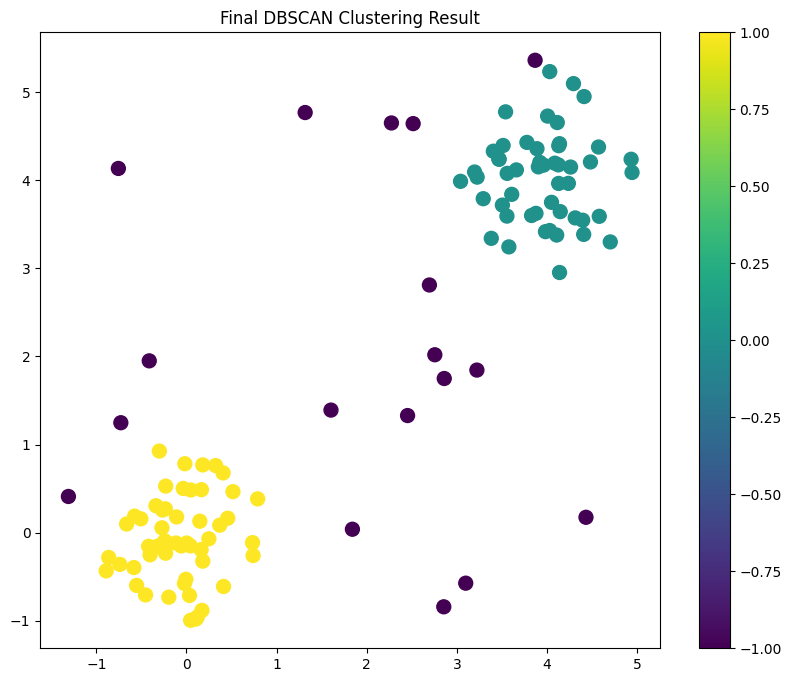

In [24]:


# 7. Final DBSCAN Result
print("\nStep 7: Final DBSCAN Clustering")
# Apply sklearn DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(X)

# Plot final results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=100)
plt.colorbar(scatter)
plt.title('Final DBSCAN Clustering Result')
plt.show()


Step 8: Effect of Different Parameters


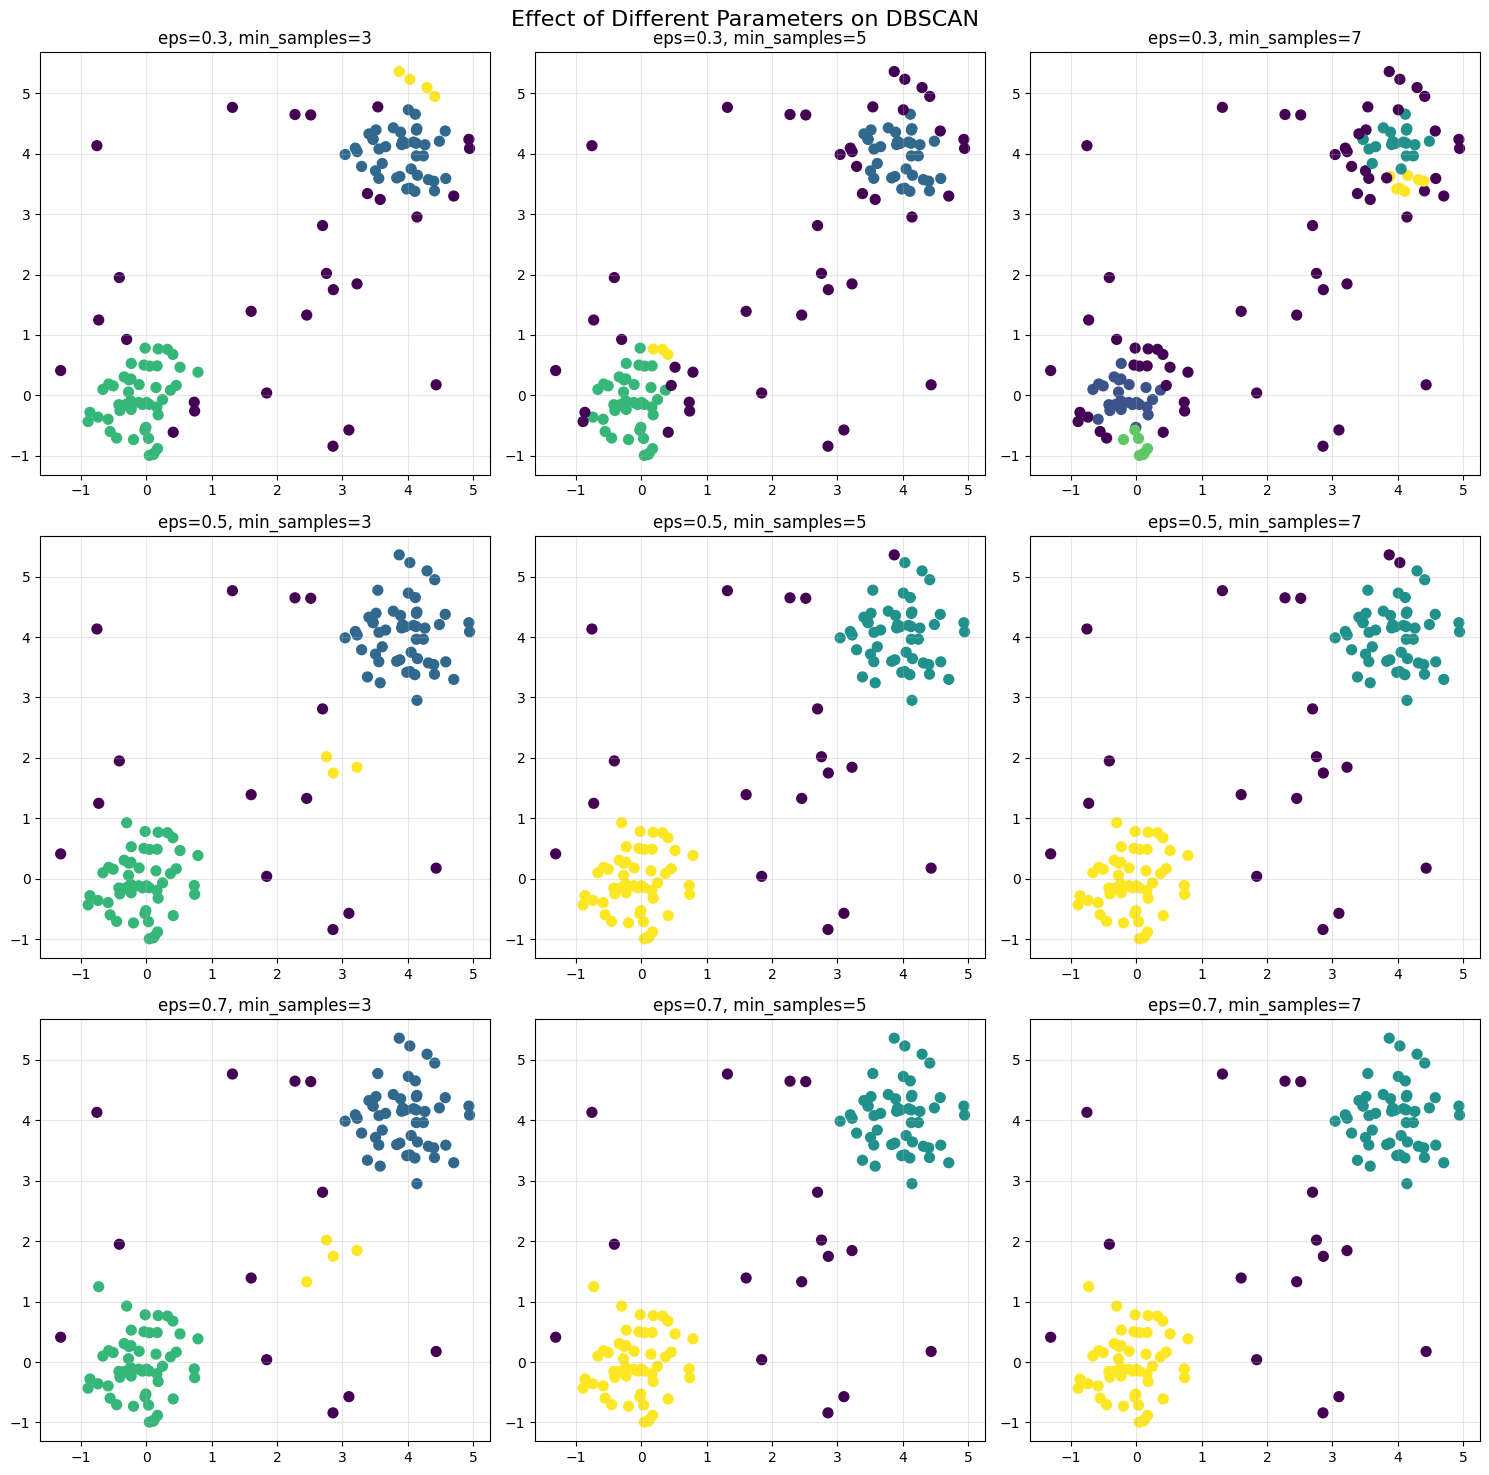

In [25]:

# 8. Effect of Parameters
print("\nStep 8: Effect of Different Parameters")
# Create a grid of different epsilon and min_samples values
epsilons = [0.3, 0.5, 0.7]
min_samples_list = [3, 5, 7]

fig, axes = plt.subplots(len(epsilons), len(min_samples_list), figsize=(15, 15))
fig.suptitle('Effect of Different Parameters on DBSCAN', fontsize=16)

for i, eps in enumerate(epsilons):
    for j, ms in enumerate(min_samples_list):
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        labels = dbscan.fit_predict(X)
        
        scatter = axes[i, j].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
        axes[i, j].set_title(f'eps={eps}, min_samples={ms}')
        axes[i, j].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Step 9: DBSCAN with Complex Shapes


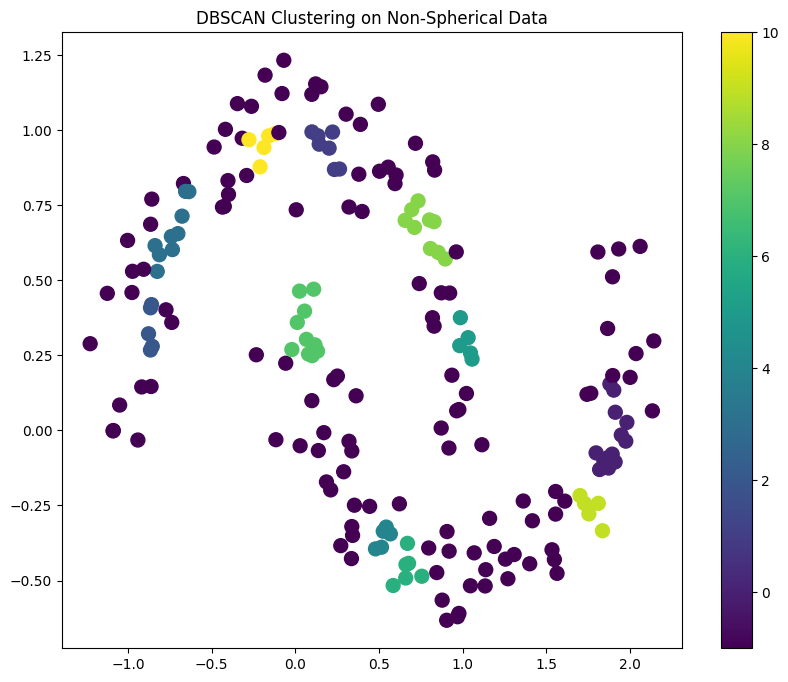

In [26]:
# 9. Example with Complex Shapes
print("\nStep 9: DBSCAN with Complex Shapes")
# Generate moon-shaped clusters
X_moons, _ = make_moons(n_samples=200, noise=0.1, random_state=42)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels_moons = dbscan.fit_predict(X_moons)

# Plot results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_moons[:, 0], X_moons[:, 1], c=labels_moons, cmap='viridis', s=100)
plt.colorbar(scatter)
plt.title('DBSCAN Clustering on Non-Spherical Data')
plt.show()

#### Clustering metrics 
**Clustering Metrics: A Comprehensive Guide**

Clustering metrics are essential tools to evaluate the quality of clusters produced by clustering algorithms. They help us assess how well-separated clusters are, how compact they are, and how well they represent the underlying data structure.

Here are some of the most commonly used clustering metrics:

**1. Silhouette Coefficient:**

* **What it measures:** How similar a data point is to its own cluster compared to other clusters.
* **Interpretation:**
   - A high value (closer to 1) indicates that the data point is well-matched to its own cluster and poorly matched to neighboring clusters.   

   - A low value (closer to -1) indicates that the data point might be assigned to the wrong cluster.
   - A value near 0 indicates overlapping clusters.

**2. Calinski-Harabasz Index:**

* **What it measures:** The ratio of the sum of between-clusters dispersion and within-cluster dispersion.
* **Interpretation:**
   - A higher value indicates better-defined clusters.
   - It rewards clusters that are far apart and compact.

**3. Davies-Bouldin Index:**

* **What it measures:** The average similarity between each cluster and its most similar cluster.
* **Interpretation:**
   - A lower value indicates better-defined clusters.
   - It penalizes clusters that are close together or have large variances.



**Choosing the Right Metric:**

The choice of metric depends on the specific characteristics of the data and the clustering algorithm used. However, a combination of metrics is often recommended to get a more comprehensive evaluation:

- **Silhouette Coefficient:** Useful for assessing the compactness and separation of clusters.
- **Calinski-Harabasz Index:** Good for evaluating the overall quality of clustering.
- **Davies-Bouldin Index:** Useful for identifying overlapping clusters.


By understanding these metrics and their interpretations, you can effectively evaluate the quality of your clustering results and make informed decisions about the best clustering algorithm and parameter settings for your specific task.


Source: https://www.geeksforgeeks.org/clustering-metrics/

K-Means Metrics:
Silhouette Score: 0.6819938690643478
Calinski-Harabasz Index: 1210.0899142587816
Davies-Bouldin Index: 0.4375640078237842

DBSCAN Metrics:
Silhouette Score: -0.025530977724335973
Calinski-Harabasz Index: 56.61504181993602
Davies-Bouldin Index: 2.346568984060926


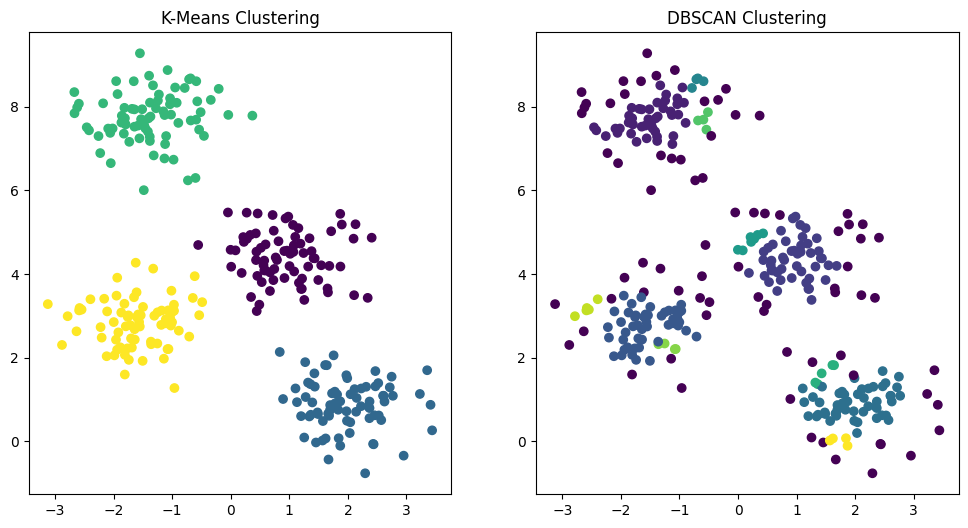

In [29]:


# Generate sample data
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
labels_kmeans = kmeans.labels_

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.3, min_samples=5).fit(X)
labels_dbscan = dbscan.labels_

# Calculate metrics
silhouette_kmeans = silhouette_score(X, labels_kmeans)
calinski_harabasz_kmeans = calinski_harabasz_score(X, labels_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(X, labels_kmeans)

silhouette_dbscan = silhouette_score(X, labels_dbscan)
calinski_harabasz_dbscan = calinski_harabasz_score(X, labels_dbscan)
davies_bouldin_dbscan = davies_bouldin_score(X, labels_dbscan)

print("K-Means Metrics:")
print("Silhouette Score:", silhouette_kmeans)
print("Calinski-Harabasz Index:", calinski_harabasz_kmeans)
print("Davies-Bouldin Index:", davies_bouldin_kmeans)

print("\nDBSCAN Metrics:")
print("Silhouette Score:", silhouette_dbscan)
print("Calinski-Harabasz Index:", calinski_harabasz_dbscan)
print("Davies-Bouldin Index:", davies_bouldin_dbscan)

# Visualize the clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans, cmap='viridis')
plt.title('K-Means Clustering')

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_dbscan, cmap='viridis')
plt.title('DBSCAN Clustering')

plt.show()